# Competition - Accident Severity

#### DS 862 - Project II
#### Authors
* Syed Asim
* Divya Raghunathan
* Sairaj Rege

# Table of Contents


* [I: Project Overview](#one)
* [II: Introduction](#two)
* [III: Exploratory Data Analysis](#three)
* [Model I : Naive Bayes](#1)
* [Model II : Neural Network](#2)
* [Model III : Support Vector Machine ](#3)
* [IV: Experimentation](#four)
* [V: Conclusion](#five)

# **I: Project Overview** <a class="anchor" id="one"></a>

The project is divided into three parts where we will build three classifiers using three models- Naive Bayes, SVM and Neural Network. The aim is to train and fit the classifiers and obtain the prediction for the test set as well as the accuracy score.

30% of the dataset with response is available for training and testing the model. The reamining the 70% of the observations will be given as the test set and the prediction results will be submitted in csv format. 

We will start off with EDA followed by each of the models



# **II: Introduction** <a class="anchor" id="two"></a>

In this notebook, we will be applying  3 classifiation models on the UK road accidents dataset. The road accidents dataset can be found here (https://www.kaggle.com/stefanoleone992/adm-project-road-accidents-in-uk). The response variable on this dataset is the Accident Severity (Slight or Fatal). The dataset contains 31 features (including the response variable) and 251832  observations (total). 

In [1]:
# General imports
from collections import Counter
import pandas as pd
import numpy as np
import warnings
warnings.simplefilter('ignore')
from sklearn.pipeline import Pipeline
import scipy.stats as stats
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import boxcox
import pickle

#NB related imports
from sklearn.naive_bayes import GaussianNB, MultinomialNB, CategoricalNB


# SVC related imports
from sklearn.svm import SVC 

# Neural Network related imports
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, Activation
from tensorflow.keras import regularizers
from keras.layers.core import Dropout
from keras.wrappers.scikit_learn import KerasClassifier
import tensorflow as tf


# To get reproducible results
from numpy.random import seed
seed(862)
from tensorflow.random import set_seed
set_seed(862)

Accident index is an unique value for each observation and further feature engineering would be required for datetime before adding it to the model. Hence, we shall drop datetime and accident index

In [2]:
# Load data set
data = pd.read_csv('RoadAccident.csv')
data.drop(['Accident_Index','Datetime'], axis = 1,inplace=True) 
data

,Latitude,Longitude,Region,Urban_or_Rural_Area,X1st_Road_Class,Driver_IMD_Decile,Speed_limit,Road_Type,Road_Surface_Conditions,Weather,...,Junction_Detail,Junction_Location,X1st_Point_of_Impact,Driver_Journey_Purpose,Engine_CC,Propulsion_Code,Vehicle_Make,Vehicle_Category,Vehicle_Manoeuvre,Accident_Severity
0,51.495653,-0.179097,London,Urban,C,7,30,Single carriageway,Dry,Fine,...,Not at junction or within 20 metres,Not at or within 20 metres of junction,Front,Other/Not known,1781,Petrol,Audi,Car,Going ahead,Slight
1,51.499635,-0.209915,London,Urban,A,3,30,Single carriageway,Dry,Fine,...,More than 4 arms (not roundabout),Mid Junction - on roundabout or on main road,Offside,Other/Not known,2987,Heavy oil,Mercedes,Car,Waiting to go,Slight
2,51.492515,-0.168130,London,Urban,Unclassified,5,30,Single carriageway,Dry,Fine,...,Crossroads,Mid Junction - on roundabout or on main road,Front,Journey as part of work,998,Petrol,Nissan,Car,Going ahead,Slight
3,51.504784,-0.193863,London,Urban,A,2,30,Single carriageway,Dry,Fine,...,T or staggered junction,Mid Junction - on roundabout or on main road,Offside,Journey as part of work,2179,Heavy oil,Citroen,Van,Turning right,Slight
4,51.522072,-0.212927,London,Urban,B,3,30,Single carriageway,Wet or damp,Fine,...,T or staggered junction,Approaching junction or waiting/parked at junc...,Nearside,Journey as part of work,2198,Heavy oil,Ford,Van,Overtaking,Slight
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
75545,56.531008,-2.945169,Scotland,Rural,A,9,70,Dual carriageway,Wet or damp,Raining,...,T or staggered junction,Approaching junction or waiting/parked at junc...,Front,Other/Not known,2199,Heavy oil,Kia,Car,Going ahead,Fatal_Serious
75546,56.677867,-3.688719,Scotland,Rural,A,10,70,Dual carriageway,Dry,Fine,...,T or staggered junction,Cleared junction or waiting/parked at junction...,Front,Other/Not known,1598,Petrol,Vauxhall,Car,Going ahead,Fatal_Serious
75547,55.720385,-2.654035,Scotland,Rural,A,9,60,Single carriageway,Dry,Fine,...,Not at junction or within 20 metres,Not at or within 20 metres of junction,Front,Other/Not known,1598,Heavy oil,Audi,Car,Going ahead,Fatal_Serious
75548,54.850068,-4.925632,Scotland,Rural,B,5,60,Single carriageway,Dry,Fine,...,Not at junction or within 20 metres,Not at or within 20 metres of junction,Front,Other/Not known,1000,Petrol,BMW,Motorcycle,Going ahead,Fatal_Serious


# **III: Exploratory Data Analysis** <a class="anchor" id="three"></a>

In [3]:
# Checking the unique observations, datatype & null values for every feature
d = {"Feature":[i for i in data.columns]    ,"Nunique" :data.nunique().values ,'Type' : data.dtypes.values, "No: of nulls" : data.isnull().sum() }
description = pd.DataFrame(data = d)
description

,Feature,Nunique,Type,No: of nulls
Latitude,Latitude,69334,float64,0
Longitude,Longitude,69663,float64,0
Region,Region,11,object,0
Urban_or_Rural_Area,Urban_or_Rural_Area,2,object,0
X1st_Road_Class,X1st_Road_Class,6,object,0
Driver_IMD_Decile,Driver_IMD_Decile,10,int64,0
Speed_limit,Speed_limit,6,int64,0
Road_Type,Road_Type,5,object,0
Road_Surface_Conditions,Road_Surface_Conditions,5,object,0
Weather,Weather,6,object,0


Observations

1.   There are no null values
2.   Some of the features are identified as a wrong type (Eg: Season, year) , we will fix this in the next step
3. Day of month seems like a categorical variable with 31 levels. Since it would be computationally heavy, we will drop it for NB and SVM

In the below code, we are converting the data type for some features by replacing the "int" type to an "object" type

In [4]:
# Season, Month_of_year, Day_of_week, Year, Datetime 
data["Season"]=data["Season"].astype(str)
data["Month_of_Year"]=data["Month_of_Year"].astype(str)
data["Day_of_Week"]=data["Day_of_Week"].astype(str)
data["Year"]=data["Year"].astype(str)
data["Number_of_Vehicles"]=data["Number_of_Vehicles"].astype(str)


## Response variable

In [5]:
Counter(data['Accident_Severity'])

Counter({'Slight': 56705, 'Fatal_Serious': 18845})

Text(0, 0.5, 'Frequency')

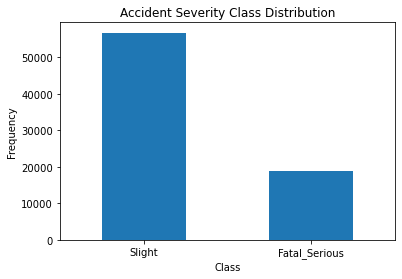

In [6]:
# Creating a plot to check class distribution
count_classes = pd.value_counts(data['Accident_Severity'], sort = True)
count_classes.plot(kind = 'bar', rot=0)
plt.title("Accident Severity Class Distribution")
plt.xlabel("Class")
plt.ylabel("Frequency")

There is some imbalance in the dataset. The "Slight" response type is approximately 3 times "Fatal serious" in terms of frequency

**Multicollinearity**

When the independent features are internally correlated with each other, it hampers the accuracy of the model because the individual contribution of the features cannot be obtained. We will use correlation matrix with heatmap to visualize the relationship of all the independent features with each other by their correlation coefficient values.

We will take a threshold of ,0.7 which means if any 2 features have a correlation above 0.7, one of the two features can be dropped.

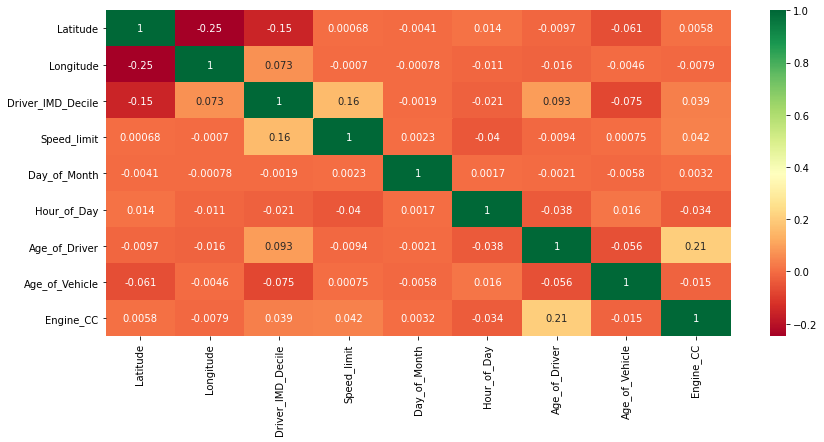

In [7]:
corrmat = data.corr()
top_corr_features = corrmat.index
plt.figure(figsize=(14,6))
#plot heat map
g=sns.heatmap(data[top_corr_features].corr(),annot=True,cmap="RdYlGn")

In [8]:
# creating this function to check if any of the predictors have multicollinearity above 0.70.
def correlation(dataset, threshold):
    col_corr = set()  # Set of all the names of correlated columns
    corr_matrix = dataset.corr()
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if abs(corr_matrix.iloc[i, j]) > threshold: # we are interested in absolute coeff value
                colname = corr_matrix.columns[i]  # getting the name of column
                col_corr.add(colname)
    return col_corr

In [9]:
corr_features = correlation(data, 0.7)
len(set(corr_features))

0

No features to remove from multicollinearity.

 **EDA- Catgeorical & Numerical**
 
 Here, we will plot count plots for the categorical data and histogram for numerical data

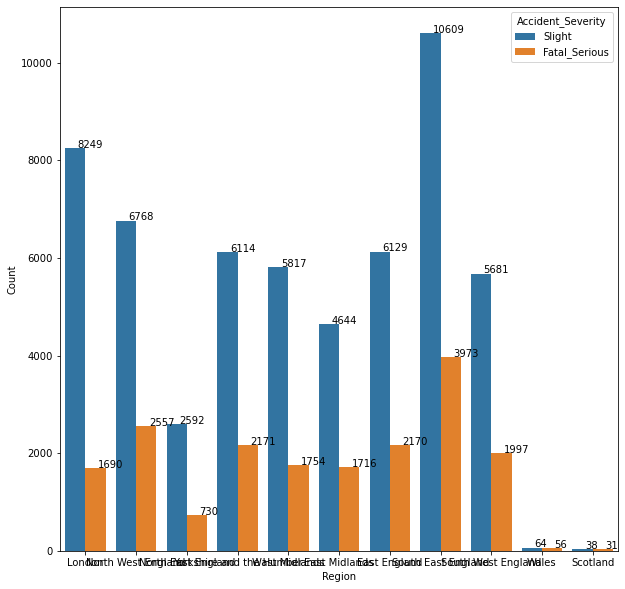

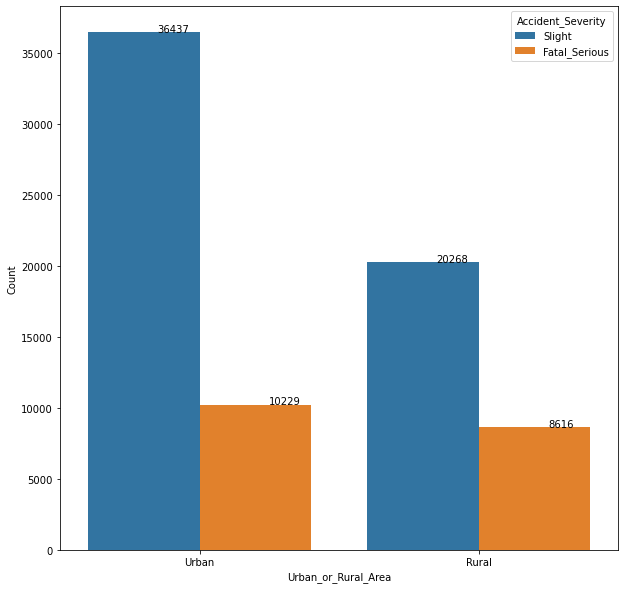

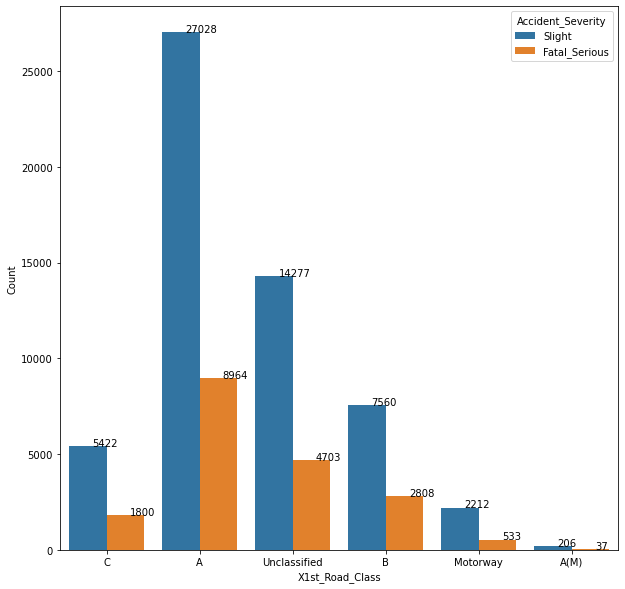

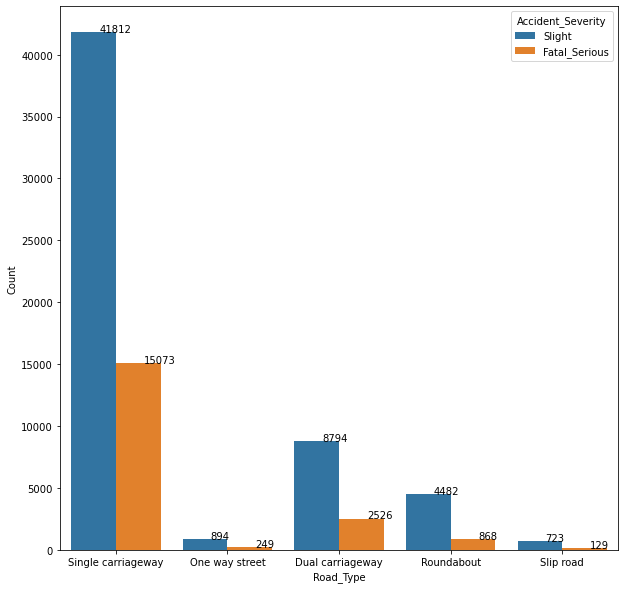

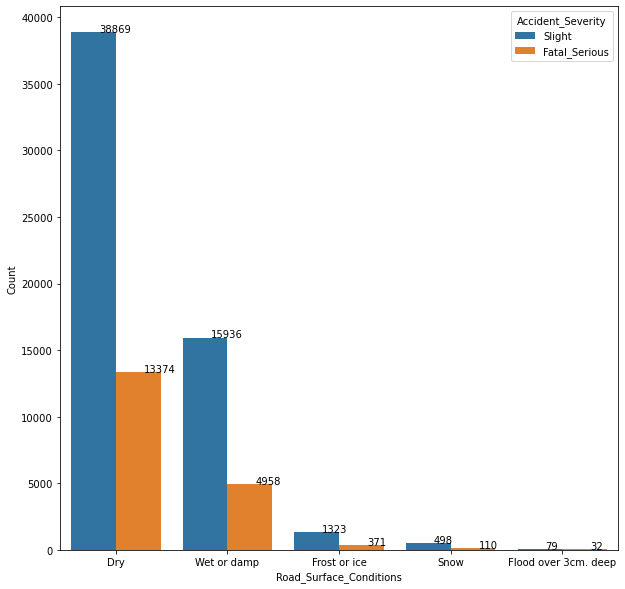

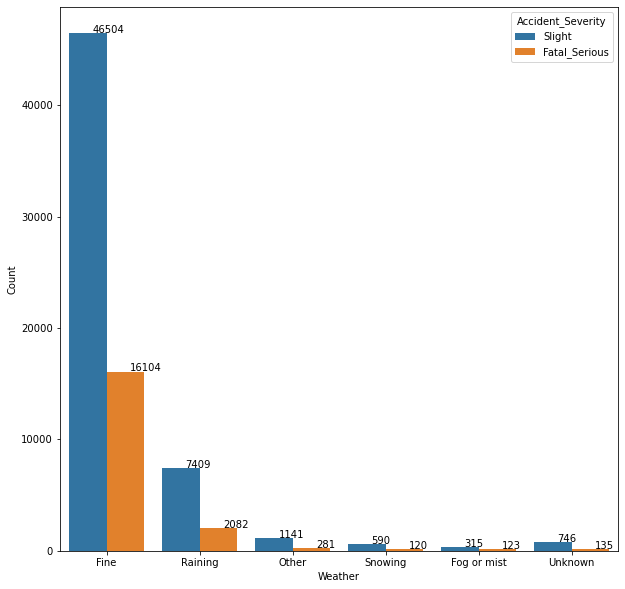

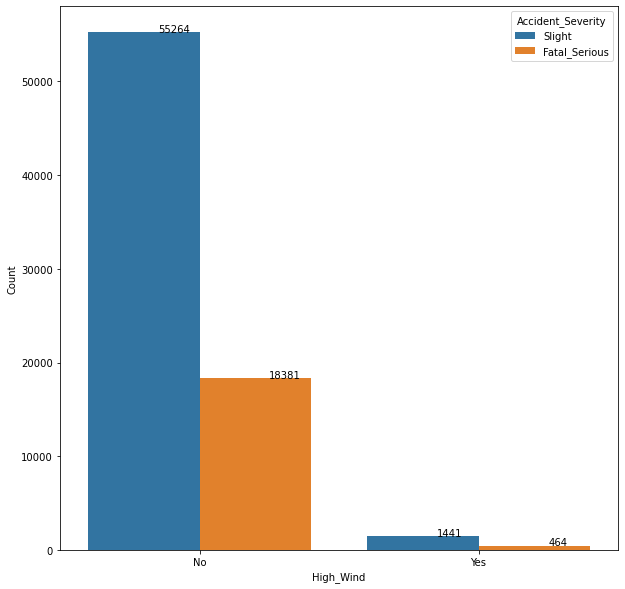

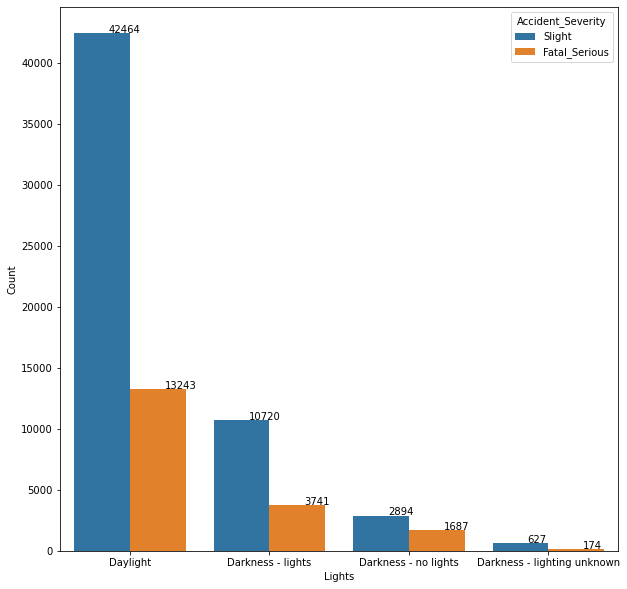

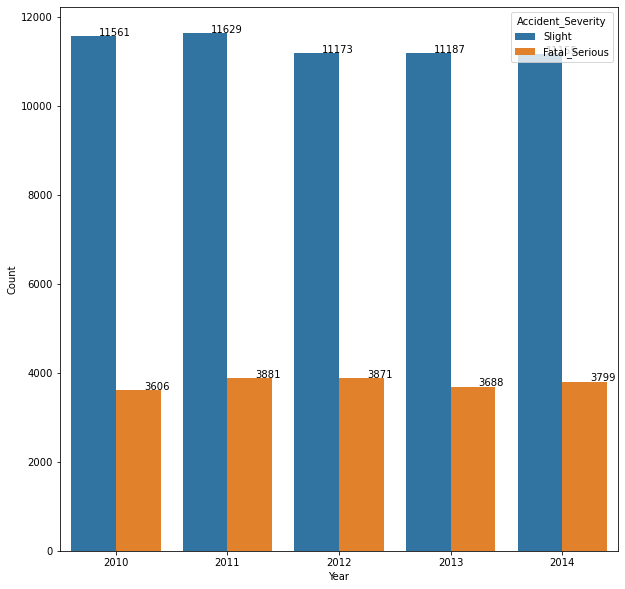

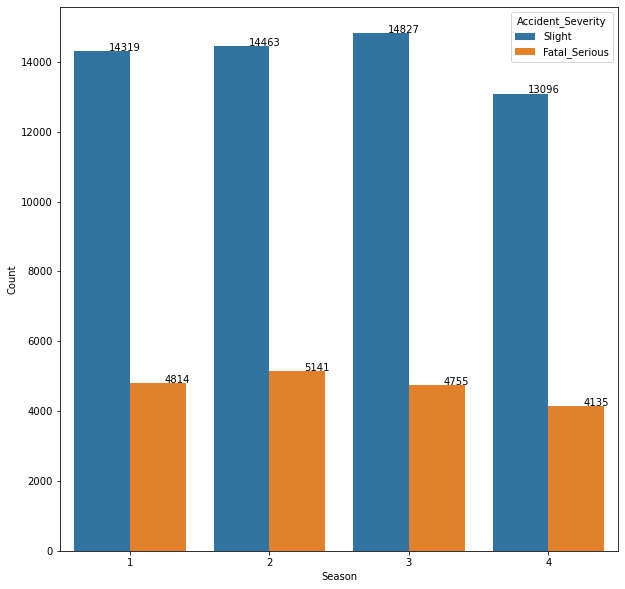

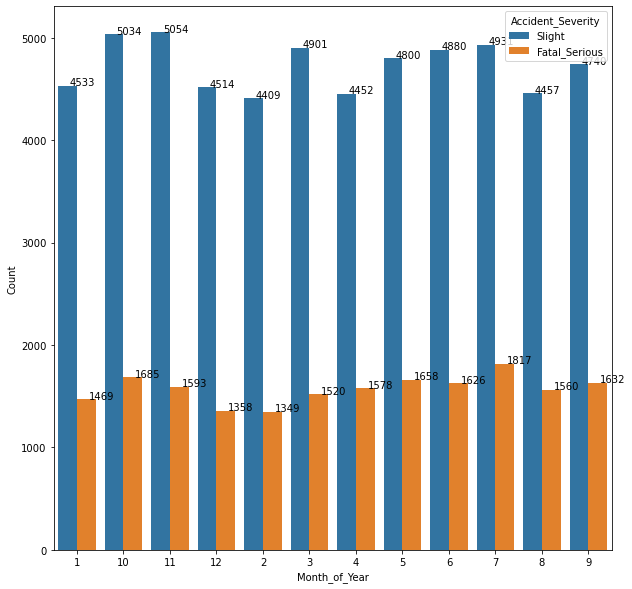

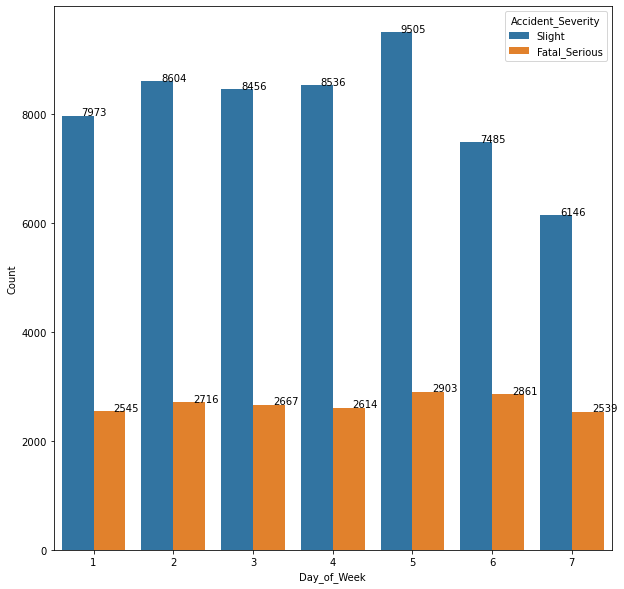

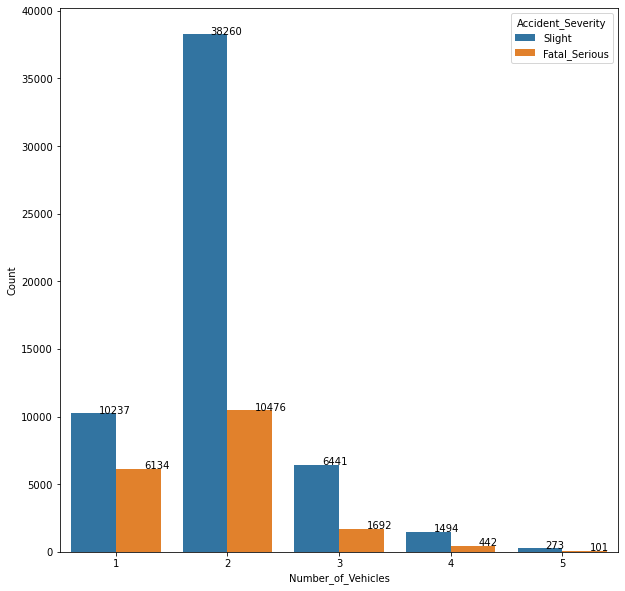

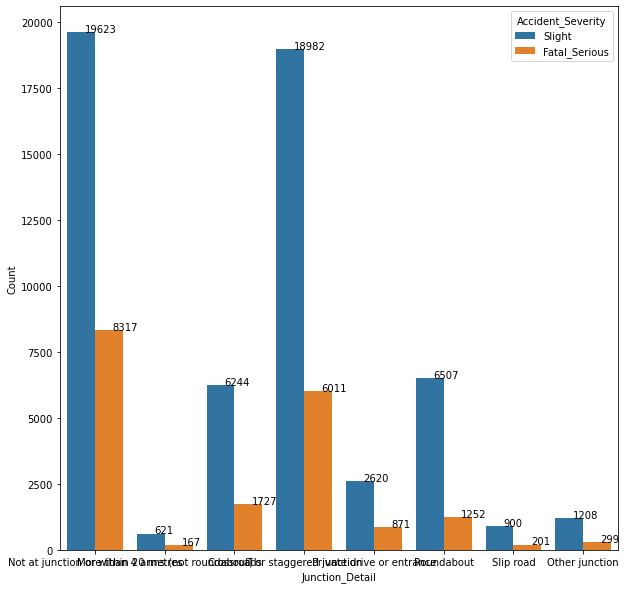

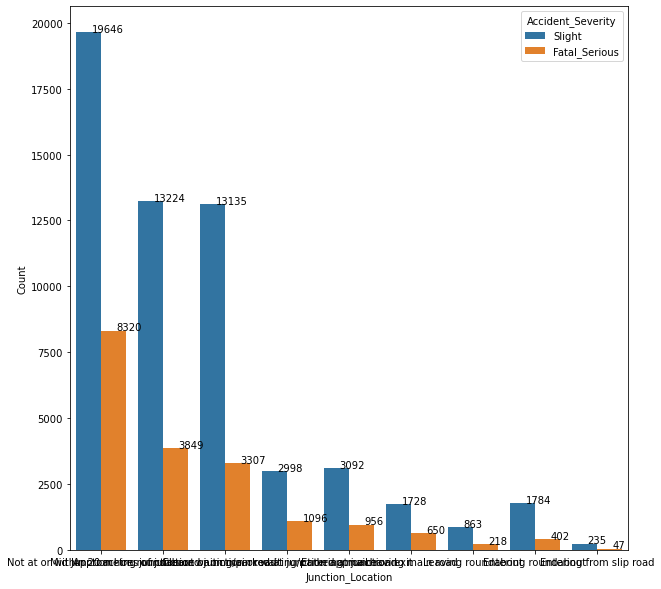

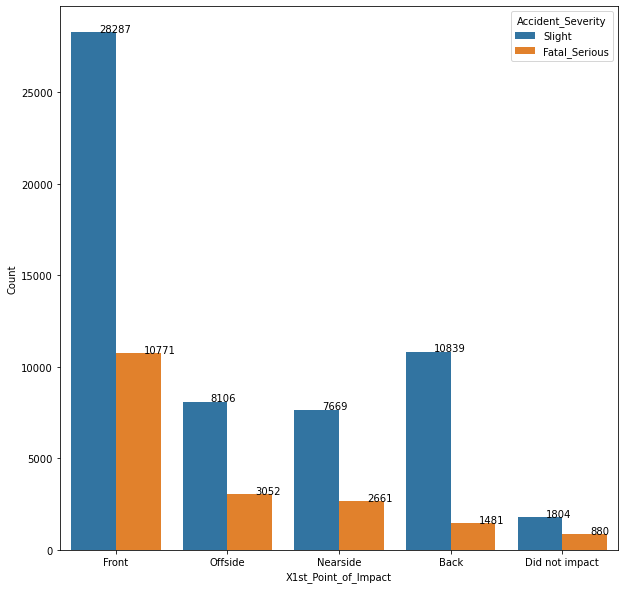

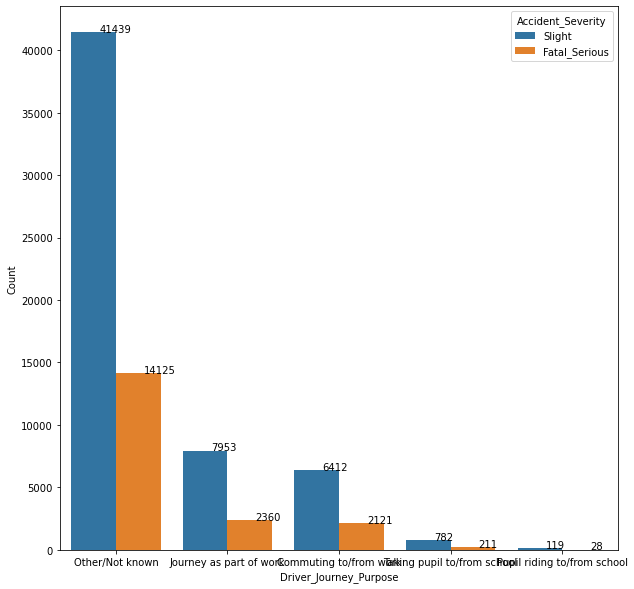

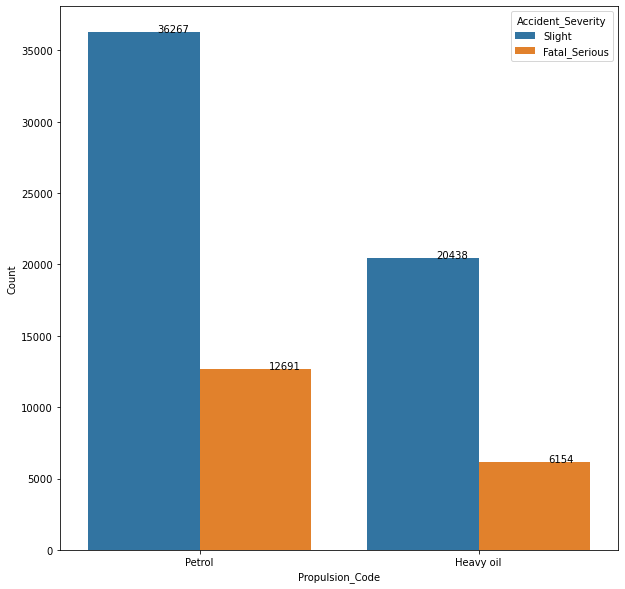

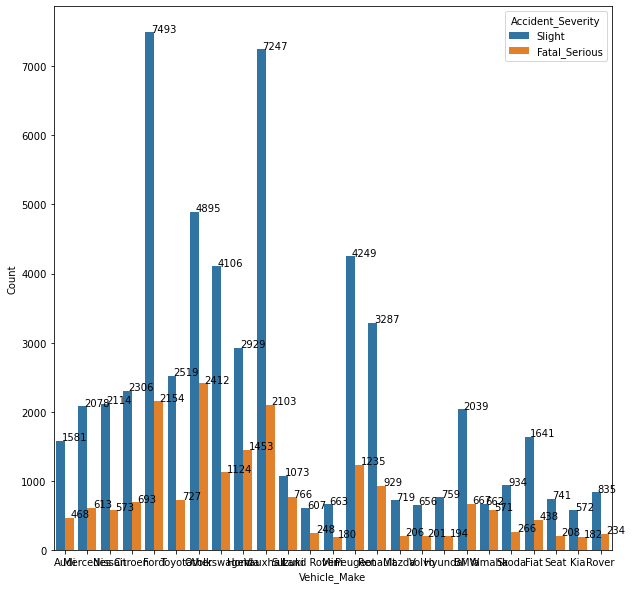

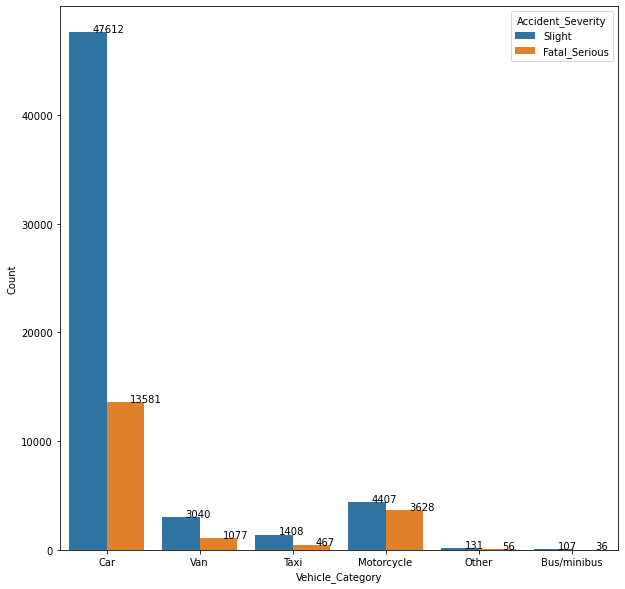

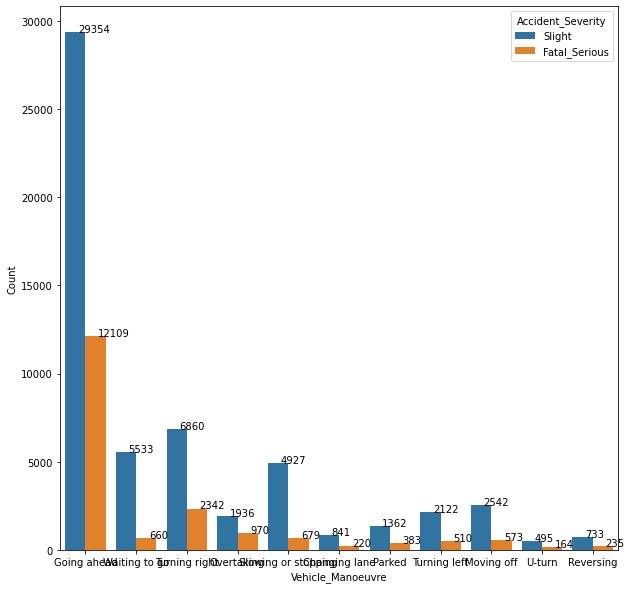

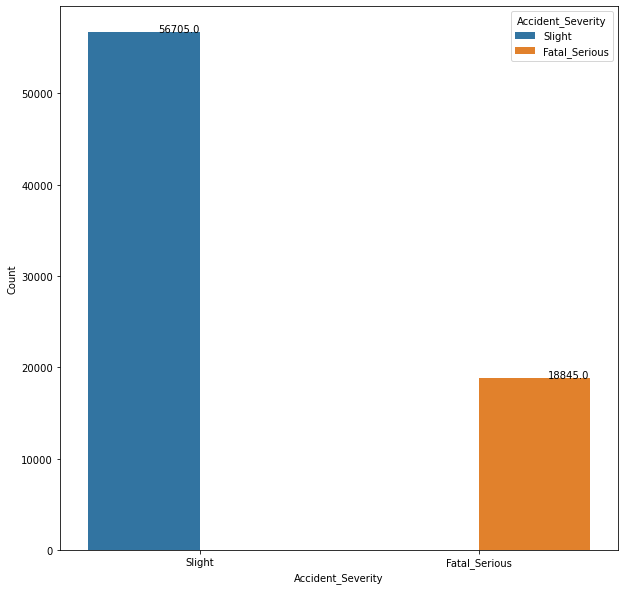

In [10]:
cat_data  = data.select_dtypes(exclude=[np.number])
for i in cat_data:  
  plt.figure(figsize=(10,10))# Creating an empty plot 
  ax=sns.countplot(x=cat_data[i],hue=data["Accident_Severity"])# Countplot of airlines
  plt.tick_params(labelsize=10)# changing the label sizes  
  plt.ylabel("Count" ,fontsize=10) #Adding y-label
  #plt.title("\n", cat_data.columns.values,"\n",fontsize=25) # Adding plot title
  for p in ax.patches:
      ax.annotate('{}'.format(p.get_height()),(p.get_x()+0.25,p.get_height()+5)) # Adding the count above the bars
  plt.show() 

In [11]:
def diagnostic_plots(df, variable):
    # function to plot a histogram and a Q-Q plot
    # side by side, for a certain variable
    
    plt.figure(figsize=(15,6))
    plt.subplot(1, 2, 1)
    df[variable].hist()
    print(str(variable))

    plt.subplot(1, 2, 2)
    stats.probplot(df[variable], dist="norm", plot=plt)

    plt.show()

Latitude


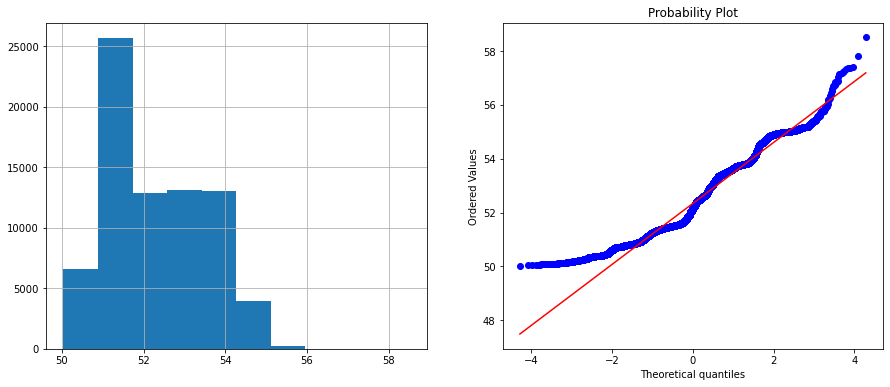

Longitude


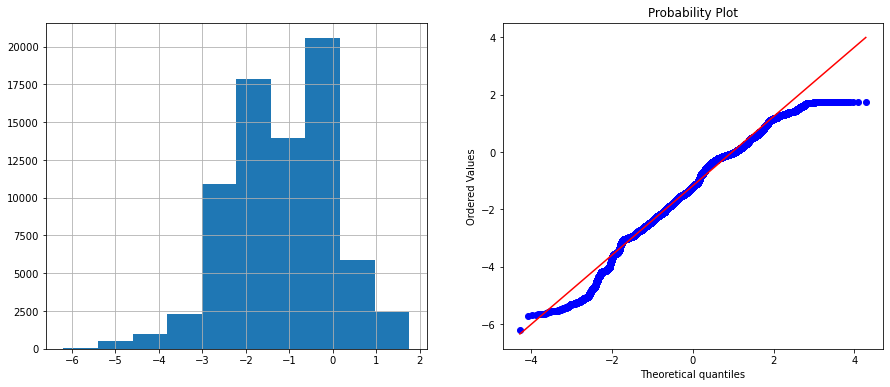

Driver_IMD_Decile


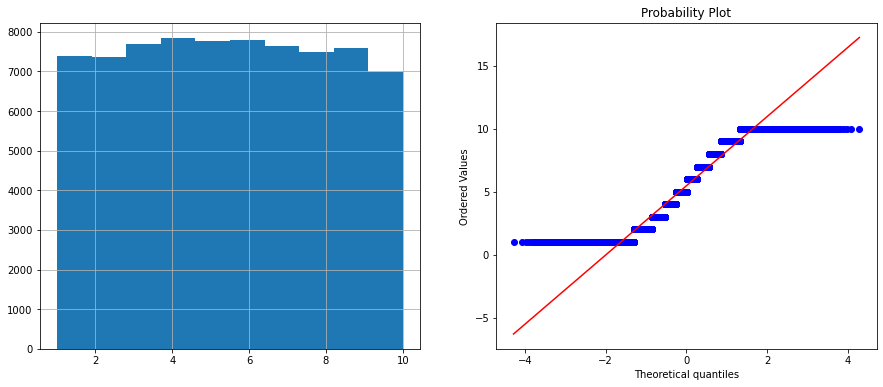

Speed_limit


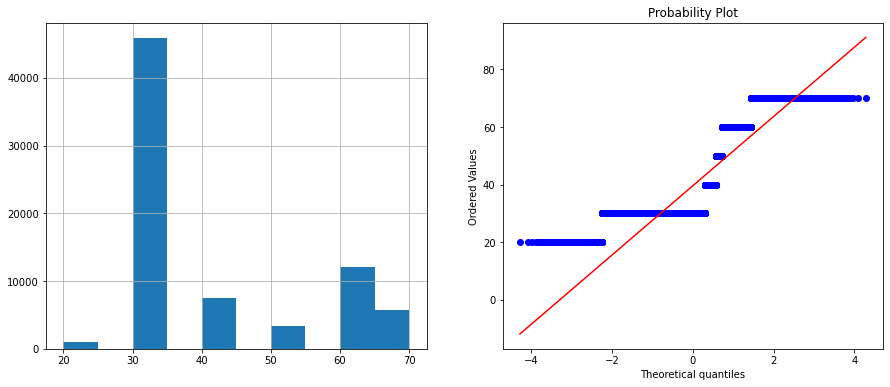

Day_of_Month


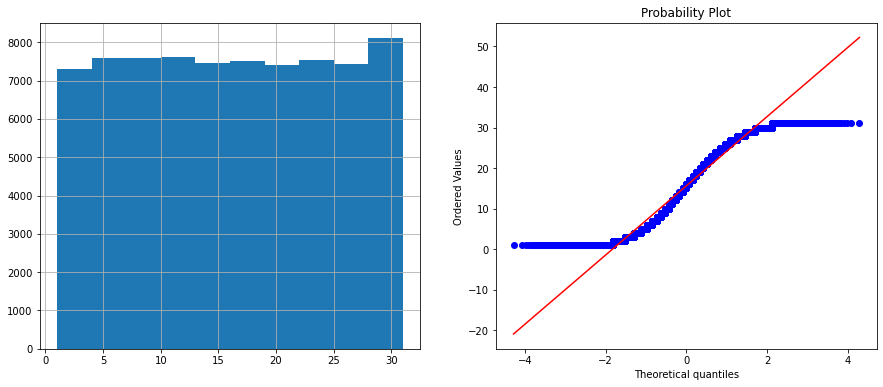

Hour_of_Day


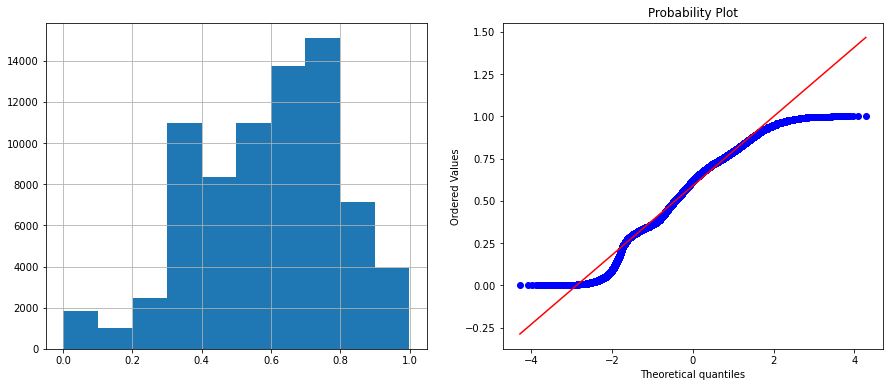

Age_of_Driver


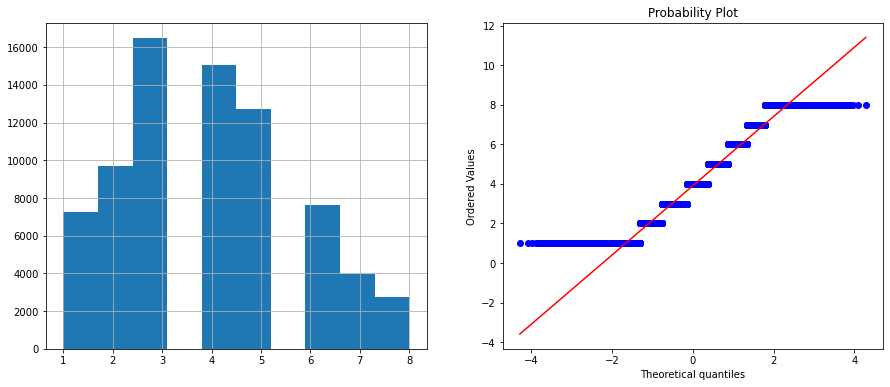

Age_of_Vehicle


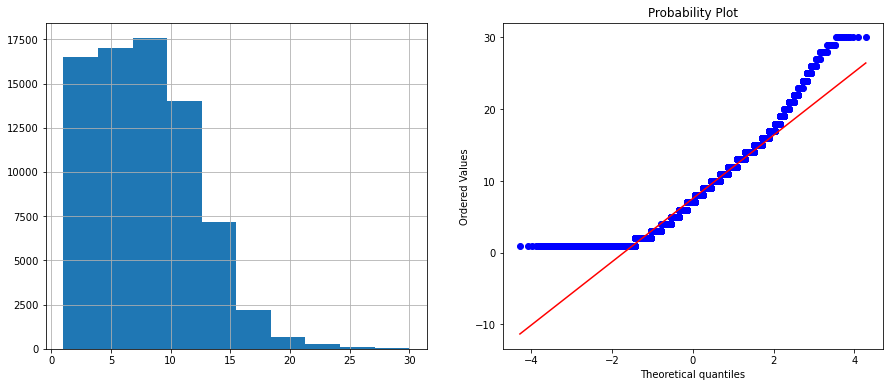

Engine_CC


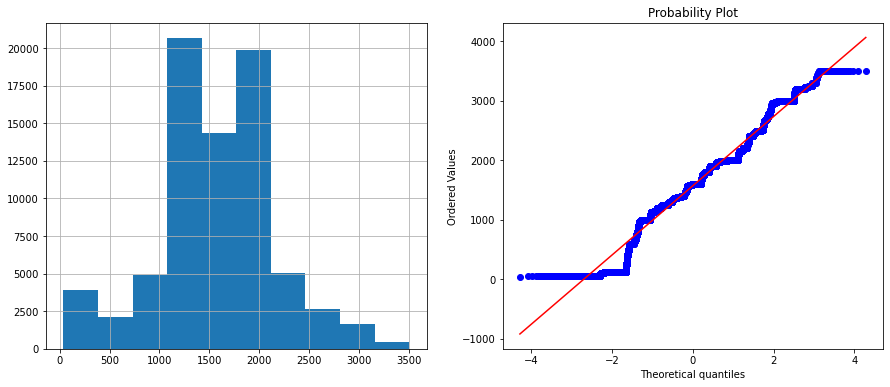

In [12]:
num_data  = data.select_dtypes(include=[np.number])
for i in num_data:
    diagnostic_plots(num_data, i) 

From the above count plot and histogram for categorical and numerical data. The following observations can be made.

1.  In categorical data, there are many classes that has very low frequency. For example, Road surface conditions has 5 classes, out of which only dry and wet have significant counts, so the rest can be grouped into one class
2.  From the numerical data- histogram plot, some features are not normally distributed. This would be taken care of depending on the classifier at a later step

In [13]:
# In categorical data, there are many classes that have very low frequency.
# We will combine some of these levels to speed up the computation time.
data["Road_Type"].replace({"Roundabout": "Others", "One way street": "Others", "Slip road": "Others"}, inplace=True)

data["Road_Surface_Conditions"].replace({"Frost or ice": "Others", "Snow": "Others", "Flood over 3cm. deep": "Others"}, inplace=True)

data["Weather"].replace({"Other": "Others", "Unknown": "Others", "Snowing": "Others", "Fog or mist":"Others"}, inplace=True)

data["Lights"].replace({"Darkness - lights": "Darkness", "Darkness - no lights": "Darkness", "Darkness - lighting unknown": "Darkness"}, inplace=True)

data["Driver_Journey_Purpose"].replace({"Journey as part of work": "Work/School", "Commuting to/from work": "Work/School", "Taking pupil to/from school": "Work/School", 
                                         "Pupil riding to/from school":"Work/School"}, inplace=True)

In [14]:
# Converting the response variable to a binary format
data['Accident_Severity'][data['Accident_Severity']=='Slight' ]=0
data['Accident_Severity'][data['Accident_Severity']=='Fatal_Serious' ]=1
data['Accident_Severity']=data['Accident_Severity'].astype(int)

# **Model 1: Naive Bayes** <a class="anchor" id="1"></a>

In the first model- Naive bayes, we will make use of only the features selected from the EDA process above. Further to this, the below steps are implemented specific to Naive Bayes


1.   Naive bayes assumes the numerical variables are normally distributed. We will perform appropriate `transformations` to the numerical data.
2.   Split the data into train and test set(60%-20% split)
3.   Further split the data into numerical and categorical.
4.   We will split the numerical data into continous and discrete.
5.   We will make use of 3 naive bayes model from the 'Sklearn' library- `Gaussian Naive Bayes` for continous data, `Categorical Naive Bayes` for categorical data and `Multinomial Naive Bayes` for discrete data. 
6. We will tune approrpiate hyperparameters for each of the model and `fit` the training data set
7. We will apply `predict_proba` and get the probabilities for each of the models using the test set.
8. We will multiply the probabilities and classify as "0" or "1" based on the higher probability. 



In [15]:
# Lets delete "day of month" as the number of classes is high and it would be computationally heavy 
# and also delete "junction location" which is very similar to "junction details"
del data['Day_of_Month']
del data['Junction_Location']

In [16]:
# As seen from the EDA, some numerical variables are not normally distributed. Lets transform them. 
#boxcox
def boxcox_(data, variable):
    data[variable], lmda= boxcox(data[variable]+1)
    return data[variable]

In [17]:
data['Age_of_Vehicle']= boxcox_(data, 'Age_of_Vehicle')
data['Latitude']=np.log(data['Latitude']+1)
# Driver IMD decide , age of driver and speed limit looks like discrete variable, so we will build a multinomialNB model
#Only age of vehicle and latitude showed improvements after transformation. Also, the trasnformations method was trial and tested and best type if applied here. 


Age_of_Vehicle


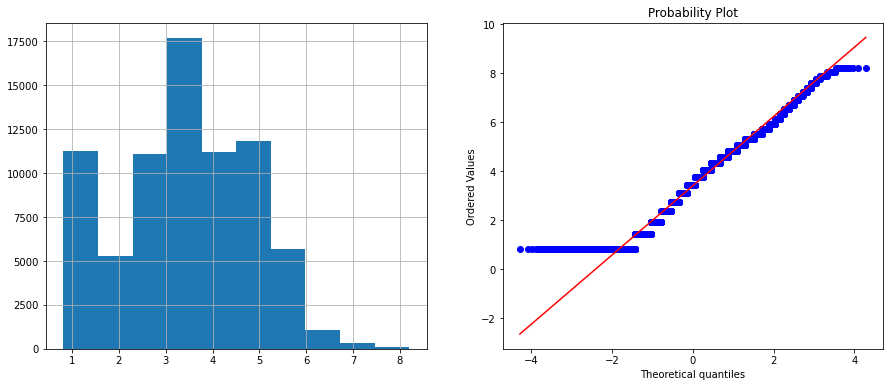

Latitude


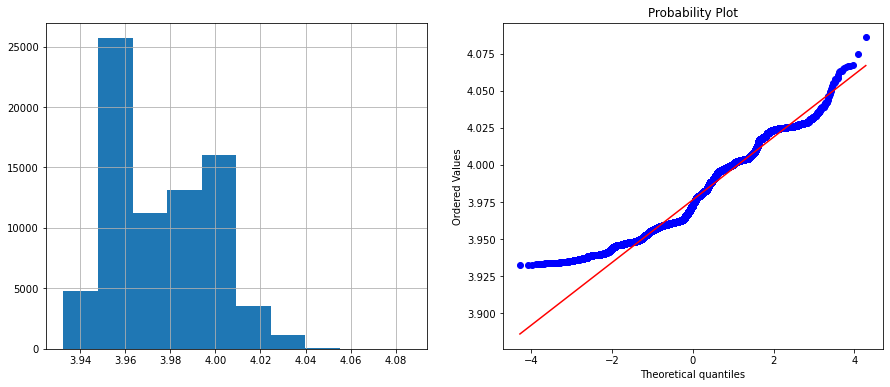

In [18]:
#Plots after transformation
num_data  = data[['Age_of_Vehicle','Latitude']]
for i in num_data:
    diagnostic_plots(num_data, i) 

In [19]:
# Defining the predictors and response variables
X = data.drop(['Accident_Severity'], axis = 1)
y = data.Accident_Severity

In [20]:
# Splitting the data
X_train_valid, X_test, y_train_valid, y_test = train_test_split(X, y, test_size = 0.2, random_state = 421)

In [21]:
'''
This function will separate the data into numerical and categorical type (object)
'''
def separate(data):
    num = data.dtypes != 'object'
    cat = data.dtypes == 'object'

    num = data[data.columns[num]]
    cat = data[data.columns[cat]]
    
    return num, cat

In [22]:
# Seperating the categorical and numerical data
X_train_valid_num,X_train_valid_cat = separate(X_train_valid)
X_test_num, X_test_cat= separate(X_test)

In [23]:
def label(ser):
  '''
  This function will label encode the categorical variables
  '''
  X_cat_new=LabelEncoder().fit_transform(ser)
  return X_cat_new

In [24]:
#Applying label encoder to the categorical data
X_train_valid_cat = X_train_valid_cat.apply(label)
X_test_cat = X_test_cat.apply(label)

#### We will split the data into 3 datasets - continous, discrete and categorical

In [25]:
X_train_valid_cont= X_train_valid_num[['Latitude','Longitude','Hour_of_Day','Age_of_Vehicle','Engine_CC']]
X_test_cont= X_test_num[['Latitude','Longitude','Hour_of_Day','Age_of_Vehicle','Engine_CC']]


X_train_valid_dist= X_train_valid_num[['Driver_IMD_Decile','Speed_limit','Age_of_Driver']]
X_test_dist= X_test_num[['Driver_IMD_Decile','Speed_limit','Age_of_Driver']]

In [26]:
# We will use these variables for the respective models
print("Continous variables \n", X_train_valid_cont.columns)
print("\nDiscrete variables \n", X_train_valid_dist.columns)
print("\nCategorical variables \n", X_test_cat.columns)

Continous variables 
 Index(['Latitude', 'Longitude', 'Hour_of_Day', 'Age_of_Vehicle', 'Engine_CC'], dtype='object')

Discrete variables 
 Index(['Driver_IMD_Decile', 'Speed_limit', 'Age_of_Driver'], dtype='object')

Categorical variables 
 Index(['Region', 'Urban_or_Rural_Area', 'X1st_Road_Class', 'Road_Type',
       'Road_Surface_Conditions', 'Weather', 'High_Wind', 'Lights', 'Year',
       'Season', 'Month_of_Year', 'Day_of_Week', 'Number_of_Vehicles',
       'Junction_Detail', 'X1st_Point_of_Impact', 'Driver_Journey_Purpose',
       'Propulsion_Code', 'Vehicle_Make', 'Vehicle_Category',
       'Vehicle_Manoeuvre'],
      dtype='object')


### Gaussian Naive Bayes

We will fit the continous features using Gaussian Naive Bayes method

In [27]:
# Setting up grid search
parameters={'var_smoothing':[0.001, 0.0001],'priors':[[.25,.75],[0.5,0.5],[.40,.60],None]} #priors helps in deciding the class probabilities, if None then the model will adjust based on the data
    
GB=GridSearchCV( estimator= GaussianNB(),param_grid = parameters,n_jobs=-1,cv=2)
    
GB.fit(X_train_valid_cont,y_train_valid)

GridSearchCV(cv=2, estimator=GaussianNB(), n_jobs=-1,
             param_grid={'priors': [[0.25, 0.75], [0.5, 0.5], [0.4, 0.6], None],
                         'var_smoothing': [0.001, 0.0001]})

In [28]:
GB.best_params_

{'priors': None, 'var_smoothing': 0.001}

In [29]:
print("Accuracy on the test set using GaussianNB after transformation: {}".format(np.mean(GB.predict(X_test_cont) == y_test)))

Accuracy on the test set using GaussianNB after transformation: 0.7515552614162806


In [30]:
print("Gaussian NB probabilities")
prob_num=GB.predict_proba(X_test_cont)
prob_num

Gaussian NB probabilities


array([[0.7827523 , 0.2172477 ],
       [0.78269675, 0.21730325],
       [0.74435347, 0.25564653],
       ...,
       [0.7443017 , 0.2556983 ],
       [0.76990531, 0.23009469],
       [0.74928128, 0.25071872]])

### Multinomial Naive Bayes

We will fit the discrete features using Multinomial Naive Bayes

In [31]:
# Setting up grid search
parameters={'alpha':[0.5,0.1,0.001, 0.0001],'class_prior':[[.25,.75],[0.5,0.5],[.40,.60],None]}
    
MB=GridSearchCV( estimator= MultinomialNB(),param_grid = parameters,n_jobs=-1,cv=2)
    
MB.fit(X_train_valid_dist,y_train_valid)

GridSearchCV(cv=2, estimator=MultinomialNB(), n_jobs=-1,
             param_grid={'alpha': [0.5, 0.1, 0.001, 0.0001],
                         'class_prior': [[0.25, 0.75], [0.5, 0.5], [0.4, 0.6],
                                         None]})

In [32]:
print("Accuracy on the test set using  Multinomial NB: {}".format(np.mean(MB.predict(X_test_dist) == y_test)))

Accuracy on the test set using  Multinomial NB: 0.7515552614162806


In [33]:
print("Multinomial  NB probabilities")
prob_dist=MB.predict_proba(X_test_dist)
prob_dist

Multinomial  NB probabilities


array([[0.75982599, 0.24017401],
       [0.75986423, 0.24013577],
       [0.73292341, 0.26707659],
       ...,
       [0.76299985, 0.23700015],
       [0.73315942, 0.26684058],
       [0.76457129, 0.23542871]])

### Categorical NB

We will fit the categorical features using Categorical Naive Bayes

In [34]:
# Setting up grid search
parameters={'alpha':[0.0001,0.001,0.05,0.5,1],'class_prior':[[.25,.75],[0.5,0.5],[.40,.60],None]}
    
catnb_grid=GridSearchCV( estimator= CategoricalNB(),param_grid = parameters,n_jobs=-1,cv=2)
    
catnb_grid.fit(X_train_valid_cat,y_train_valid)

GridSearchCV(cv=2, estimator=CategoricalNB(), n_jobs=-1,
             param_grid={'alpha': [0.0001, 0.001, 0.05, 0.5, 1],
                         'class_prior': [[0.25, 0.75], [0.5, 0.5], [0.4, 0.6],
                                         None]})

In [35]:
catnb_grid.best_params_

{'alpha': 0.5, 'class_prior': None}

In [36]:
print("Accuracy on the test set using CategoricalNB: {}".format(np.mean(catnb_grid.predict(X_test_cat)==y_test)))

Accuracy on the test set using CategoricalNB: 0.7375909993381866


In [37]:
print("Categorical NB probabilities")
prob_cat=catnb_grid.predict_proba(X_test_cat)
prob_cat

Categorical NB probabilities


array([[0.98701417, 0.01298583],
       [0.84283481, 0.15716519],
       [0.83996898, 0.16003102],
       ...,
       [0.60330375, 0.39669625],
       [0.83809241, 0.16190759],
       [0.61543347, 0.38456653]])

### Gaussian, Multinomial, Categorical - Probability

We will find the final probability by multiplying the probabilities obtained by gaussian, categorical and multinomial

In [38]:
total_prob=prob_cat*prob_num*prob_dist
total_prob

array([[0.58703215, 0.00067756],
       [0.50127032, 0.00820124],
       [0.45824851, 0.01092647],
       ...,
       [0.34261746, 0.02404   ],
       [0.47307243, 0.0099409 ],
       [0.35256889, 0.02269957]])

In [39]:
"""
Function that takes in the probability array (0,1) and decides the prediction based on the higher probability
"""
def NB(all_prob):
    yhat=[]
    for i,j in all_prob:
        if max(i,j)==i:
            yhat.append(0)
        else:
            yhat.append(1)
    return yhat

In [40]:
print("Accuracy on the test set for Naive bayes: ",np.mean(NB(total_prob)==y_test))

Accuracy on the test set for Naive bayes:  0.7540039708802118


In [41]:
print("yhat\n")
print(NB(total_prob), sep = ", ")

yhat

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

In [42]:
"""
This function takes in the X_test dataset and performs all the X test implementations as above and returns the predictions (yhat) for Naive Bayes model
"""
def test_NB(data):
    data2=pd.read_csv(data)
    data2.drop(['Accident_Index','Datetime','Day_of_Month','Junction_Location'], axis = 1,inplace=True)
    data2["Season"]=data2["Season"].astype(str)
    data2["Month_of_Year"]=data2["Month_of_Year"].astype(str)
    data2["Day_of_Week"]=data2["Day_of_Week"].astype(str)
    data2["Year"]=data2["Year"].astype(str)
    data2["Season"]=data2["Season"].astype(str)
    data2["Number_of_Vehicles"]=data2["Number_of_Vehicles"].astype(str)
    data2["Road_Type"].replace({"Roundabout": "Others", "One way street": "Others", "Slip road": "Others"}, inplace=True)
    data2["Road_Surface_Conditions"].replace({"Frost or ice": "Others", "Snow": "Others", "Flood over 3cm. deep": "Others"}, inplace=True)
    data2["Weather"].replace({"Other": "Others", "Unknown": "Others", "Snowing": "Others", "Fog or mist":"Others"}, inplace=True)
    data2["Lights"].replace({"Darkness - lights": "Darkness", "Darkness - no lights": "Darkness", "Darkness - lighting unknown": "Darkness"}, inplace=True)
    data2["Driver_Journey_Purpose"].replace({"Journey as part of work": "Work/School", "Commuting to/from work": "Work/School", "Taking pupil to/from school": "Work/School", 
                                        "Pupil riding to/from school":"Work/School"}, inplace=True)
    data2['Age_of_Vehicle']= boxcox_(data2, 'Age_of_Vehicle')
    data2['Latitude']=np.log(data2['Latitude']+1)
    X_test2_num, X_test2_cat= separate(data2)
    X_test2_cat = X_test2_cat.apply(label)
    X_test2_cont= X_test2_num[['Latitude','Longitude','Hour_of_Day','Age_of_Vehicle','Engine_CC']]
    X_test2_dist= X_test2_num[['Driver_IMD_Decile','Speed_limit','Age_of_Driver']]
    prob_num=GB.predict_proba(X_test2_cont)
    prob_cat=catnb_grid.predict_proba(X_test2_cat)
    prob_dist=MB.predict_proba(X_test2_dist)
    total_prob=prob_cat*prob_num*prob_dist
    predictions=NB(total_prob)
    return predictions

# **Model II: Neural Network** <a class="anchor" id="2"></a>

For this model we will reload the complete data again since when we used the above filtered data post the changes from exploratory data analysis, the results which we got were not good. For this reason, we are importing the complete dataset again.

In [43]:
# Importing the dataset
data_NN = pd.read_csv('RoadAccident.csv')
data_NN.drop(['Accident_Index','Datetime'], axis = 1,inplace=True) 

# Changing the values of the response variable
data_NN['Accident_Severity'][data_NN['Accident_Severity']=='Slight' ]=0
data_NN['Accident_Severity'][data_NN['Accident_Severity']=='Fatal_Serious' ]=1
data_NN['Accident_Severity']=data_NN['Accident_Severity'].astype(int)

data_NN.head(3)

,Latitude,Longitude,Region,Urban_or_Rural_Area,X1st_Road_Class,Driver_IMD_Decile,Speed_limit,Road_Type,Road_Surface_Conditions,Weather,...,Junction_Detail,Junction_Location,X1st_Point_of_Impact,Driver_Journey_Purpose,Engine_CC,Propulsion_Code,Vehicle_Make,Vehicle_Category,Vehicle_Manoeuvre,Accident_Severity
0,51.495653,-0.179097,London,Urban,C,7,30,Single carriageway,Dry,Fine,...,Not at junction or within 20 metres,Not at or within 20 metres of junction,Front,Other/Not known,1781,Petrol,Audi,Car,Going ahead,0
1,51.499635,-0.209915,London,Urban,A,3,30,Single carriageway,Dry,Fine,...,More than 4 arms (not roundabout),Mid Junction - on roundabout or on main road,Offside,Other/Not known,2987,Heavy oil,Mercedes,Car,Waiting to go,0
2,51.492515,-0.168130,London,Urban,Unclassified,5,30,Single carriageway,Dry,Fine,...,Crossroads,Mid Junction - on roundabout or on main road,Front,Journey as part of work,998,Petrol,Nissan,Car,Going ahead,0


In [44]:
# Defining the predictors and response variables
X = data_NN.drop(['Accident_Severity'], axis = 1)
y = data_NN.Accident_Severity

In [45]:
# Converting the predictors into dummies
X_dummies=pd.get_dummies(X,drop_first=True)
X_dummies.head(3)

,Latitude,Longitude,Driver_IMD_Decile,Speed_limit,Year,Season,Month_of_Year,Day_of_Month,Day_of_Week,Hour_of_Day,...,Vehicle_Manoeuvre_Going ahead,Vehicle_Manoeuvre_Moving off,Vehicle_Manoeuvre_Overtaking,Vehicle_Manoeuvre_Parked,Vehicle_Manoeuvre_Reversing,Vehicle_Manoeuvre_Slowing or stopping,Vehicle_Manoeuvre_Turning left,Vehicle_Manoeuvre_Turning right,Vehicle_Manoeuvre_U-turn,Vehicle_Manoeuvre_Waiting to go
0,51.495653,-0.179097,7,30,2010,4,1,19,2,0.729,...,1,0,0,0,0,0,0,0,0,0
1,51.499635,-0.209915,3,30,2010,4,2,8,1,0.475,...,0,0,0,0,0,0,0,0,0,1
2,51.492515,-0.168130,5,30,2010,4,3,3,3,0.267,...,1,0,0,0,0,0,0,0,0,0


In [46]:
# Dividing the data into train valid and test set
X_train_full, X_test, y_train_full, y_test = train_test_split(X_dummies, y, test_size = 0.35, random_state = 862,stratify=y)
X_train, X_valid, y_train, y_valid = train_test_split(X_train_full, y_train_full, random_state = 862)

In [47]:
# Scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_valid_scaled = scaler.transform(X_valid)
X_test_scaled = scaler.transform(X_test)

Now we will build our neural network classification model using different combinations of hyperparameters and find the best combination based on the validation accuracy. We will use GridSearchCV for this task by creating a wrapper for our Keras model so that it can mimic a regular SkLearn model.

The tuning parameters used are:
1. Number of hidden layers
2. Number of neurons
3. Activation function
4. Learning rate
5. Momentum
6. Dropout

In [48]:
set_seed(862) #setting the seed

def build_model(layer_hidden, actfn = 'relu', learn_rate=0.001, momentum=0.7, dropout=0.10):
    model = Sequential() # Instantiate the model
    options = {"input_dim": X_train_scaled.shape[1]} # Set options
    for layer in layer_hidden:
            model.add(Dense(layer, activation = actfn,  kernel_regularizer=regularizers.l2(1e-3),
    activity_regularizer=regularizers.l1(1e-2),**options)), # Other output layers
            model.add(Dropout(dropout))
            options = {} 
    model.add(Dense(1, activation = 'sigmoid')) # Output layer
    model.compile(loss = 'BinaryCrossentropy', optimizer = tf.keras.optimizers.Adam(learn_rate, momentum), metrics = 'accuracy')
    return model

# Creating wrapper around the function
keras_clf = tf.keras.wrappers.scikit_learn.KerasClassifier(build_model) 

# Set up the tuning parameters and grid search
param = {'layer_hidden': [(3,5,8),(100,50,30,75,40)],
        'actfn': ['relu','sigmoid'],
         'learn_rate':[0.001,0.0001],
         'momentum': [0.7,0.8],
         'dropout': [0.15,0.25]}


kfold = StratifiedKFold(n_splits=2, shuffle=True)
grd_cv = GridSearchCV(keras_clf, param, cv = kfold, n_jobs = -1)

# Fit the model
grd_cv.fit(X_train_scaled, y_train, epochs = 40, validation_data = (X_valid_scaled, y_valid),
          callbacks = tf.keras.callbacks.EarlyStopping(monitor = 'val_accuracy', patience=5), batch_size=32)

Epoch 1/40
1151/1151 [==============================] - 2s 1ms/step - loss: 0.6072 - accuracy: 0.7342 - val_loss: 0.5652 - val_accuracy: 0.7474
Epoch 2/40
1151/1151 [==============================] - 1s 1ms/step - loss: 0.5611 - accuracy: 0.7564 - val_loss: 0.5526 - val_accuracy: 0.7518
Epoch 3/40
1151/1151 [==============================] - 1s 1ms/step - loss: 0.5540 - accuracy: 0.7557 - val_loss: 0.5486 - val_accuracy: 0.7519
Epoch 4/40
1151/1151 [==============================] - 1s 1ms/step - loss: 0.5490 - accuracy: 0.7576 - val_loss: 0.5458 - val_accuracy: 0.7552
Epoch 5/40
1151/1151 [==============================] - 1s 1ms/step - loss: 0.5473 - accuracy: 0.7562 - val_loss: 0.5433 - val_accuracy: 0.7540
Epoch 6/40
1151/1151 [==============================] - 1s 1ms/step - loss: 0.5440 - accuracy: 0.7574 - val_loss: 0.5432 - val_accuracy: 0.7549
Epoch 7/40
1151/1151 [==============================] - 1s 1ms/step - loss: 0.5420 - accuracy: 0.7584 - val_loss: 0.5422 - val_accuracy:

GridSearchCV(cv=StratifiedKFold(n_splits=2, random_state=None, shuffle=True),
             estimator=<tensorflow.python.keras.wrappers.scikit_learn.KerasClassifier object at 0x000002304D32E0A0>,
             n_jobs=-1,
             param_grid={'actfn': ['relu', 'sigmoid'], 'dropout': [0.15, 0.25],
                         'layer_hidden': [(3, 5, 8), (100, 50, 30, 75, 40)],
                         'learn_rate': [0.001, 0.0001],
                         'momentum': [0.7, 0.8]})

In [49]:
grd_cv.best_params_ # Best parameters

{'actfn': 'relu',
 'dropout': 0.15,
 'layer_hidden': (3, 5, 8),
 'learn_rate': 0.001,
 'momentum': 0.7}

In [50]:
print("Accuracy on test set for Neural Network: {} ".format(np.mean((grd_cv.predict(X_test_scaled)) == np.array(y_test))) )       

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
Accuracy on test set for Neural Network: 0.743394406856083 


# **Model III: Support Vector Machine** <a class="anchor" id="3"></a>

For support vector machine, we will use the same data from above after removing "datetime" and " Index". Since SVM is computationally heavy, we will apply the data processing steps based on the EDA done above. 

In [51]:
data=data_NN.copy()

In [52]:
data.head()

,Latitude,Longitude,Region,Urban_or_Rural_Area,X1st_Road_Class,Driver_IMD_Decile,Speed_limit,Road_Type,Road_Surface_Conditions,Weather,...,Junction_Detail,Junction_Location,X1st_Point_of_Impact,Driver_Journey_Purpose,Engine_CC,Propulsion_Code,Vehicle_Make,Vehicle_Category,Vehicle_Manoeuvre,Accident_Severity
0,51.495653,-0.179097,London,Urban,C,7,30,Single carriageway,Dry,Fine,...,Not at junction or within 20 metres,Not at or within 20 metres of junction,Front,Other/Not known,1781,Petrol,Audi,Car,Going ahead,0
1,51.499635,-0.209915,London,Urban,A,3,30,Single carriageway,Dry,Fine,...,More than 4 arms (not roundabout),Mid Junction - on roundabout or on main road,Offside,Other/Not known,2987,Heavy oil,Mercedes,Car,Waiting to go,0
2,51.492515,-0.168130,London,Urban,Unclassified,5,30,Single carriageway,Dry,Fine,...,Crossroads,Mid Junction - on roundabout or on main road,Front,Journey as part of work,998,Petrol,Nissan,Car,Going ahead,0
3,51.504784,-0.193863,London,Urban,A,2,30,Single carriageway,Dry,Fine,...,T or staggered junction,Mid Junction - on roundabout or on main road,Offside,Journey as part of work,2179,Heavy oil,Citroen,Van,Turning right,0
4,51.522072,-0.212927,London,Urban,B,3,30,Single carriageway,Wet or damp,Fine,...,T or staggered junction,Approaching junction or waiting/parked at junc...,Nearside,Journey as part of work,2198,Heavy oil,Ford,Van,Overtaking,0


In [53]:
# In categorical data, there are many classes that has very low frequency.We will combine some of these levels to speed up the computation time
data["Road_Type"].replace({"Roundabout": "Others", "One way street": "Others", "Slip road": "Others"}, inplace=True)

data["Road_Surface_Conditions"].replace({"Frost or ice": "Others", "Snow": "Others", "Flood over 3cm. deep": "Others"}, inplace=True)

data["Weather"].replace({"Other": "Others", "Unknown": "Others", "Snowing": "Others", "Fog or mist":"Others"}, inplace=True)

data["Lights"].replace({"Darkness - lights": "Darkness", "Darkness - no lights": "Darkness", "Darkness - lighting unknown": "Darkness"}, inplace=True)

data["Driver_Journey_Purpose"].replace({"Journey as part of work": "Work/School", "Commuting to/from work": "Work/School", "Taking pupil to/from school": "Work/School", 
                                         "Pupil riding to/from school":"Work/School"}, inplace=True)
#In the below code, we are converting the data type for some features by replacing the "int" type to an "object" type
data["Season"]=data["Season"].astype(str)
data["Month_of_Year"]=data["Month_of_Year"].astype(str)
data["Day_of_Week"]=data["Day_of_Week"].astype(str)
data["Year"]=data["Year"].astype(str)
data["Number_of_Vehicles"]=data["Number_of_Vehicles"].astype(str)

In [54]:
# Lets delete "day of month" as the number of classes is high and it would be computationally heavy  and also delete "junction location" is very similar to "junction details"
data.drop(['Day_of_Month','Junction_Location'],axis=1, inplace=True)

In [55]:
# Defining response and predictors 
X = data.drop(['Accident_Severity'], axis = 1)
y = data.Accident_Severity

In [56]:
# Creating dummies
X_dummies=pd.get_dummies(X,drop_first=True)
X_dummies

,Latitude,Longitude,Driver_IMD_Decile,Speed_limit,Hour_of_Day,Age_of_Driver,Age_of_Vehicle,Engine_CC,Region_East Midlands,Region_London,...,Vehicle_Manoeuvre_Going ahead,Vehicle_Manoeuvre_Moving off,Vehicle_Manoeuvre_Overtaking,Vehicle_Manoeuvre_Parked,Vehicle_Manoeuvre_Reversing,Vehicle_Manoeuvre_Slowing or stopping,Vehicle_Manoeuvre_Turning left,Vehicle_Manoeuvre_Turning right,Vehicle_Manoeuvre_U-turn,Vehicle_Manoeuvre_Waiting to go
0,51.495653,-0.179097,7,30,0.729,7,8,1781,0,1,...,1,0,0,0,0,0,0,0,0,0
1,51.499635,-0.209915,3,30,0.475,5,2,2987,0,1,...,0,0,0,0,0,0,0,0,0,1
2,51.492515,-0.168130,5,30,0.267,5,11,998,0,1,...,1,0,0,0,0,0,0,0,0,0
3,51.504784,-0.193863,2,30,0.566,3,5,2179,0,1,...,0,0,0,0,0,0,0,1,0,0
4,51.522072,-0.212927,3,30,0.670,4,4,2198,0,1,...,0,0,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
75545,56.531008,-2.945169,9,70,0.764,3,1,2199,0,0,...,1,0,0,0,0,0,0,0,0,0
75546,56.677867,-3.688719,10,70,0.660,6,4,1598,0,0,...,1,0,0,0,0,0,0,0,0,0
75547,55.720385,-2.654035,9,60,0.504,3,3,1598,0,0,...,1,0,0,0,0,0,0,0,0,0
75548,54.850068,-4.925632,5,60,0.661,6,29,1000,0,0,...,1,0,0,0,0,0,0,0,0,0


In [57]:
# Splitting the data
X_train, X_test, y_train, y_test = train_test_split(X_dummies, y, test_size = 0.5, random_state = 42, stratify=y)

In [58]:
#Scaling the data
scale = StandardScaler()
X_train_s = scale.fit_transform(X_train)
X_test_s = scale.transform(X_test)

In [59]:
# Setting up the randomized search cv
parameters={'C':[0.001,0.0001], 'kernel':['linear','poly']} #Adding two hyperparameter for tuning- C and kernel types
    
svm_grid=RandomizedSearchCV(estimator= SVC(random_state=42),param_distributions = parameters,n_jobs=-1,cv=2)
    
svm_grid.fit(X_train_s,y_train)

RandomizedSearchCV(cv=2, estimator=SVC(random_state=42), n_jobs=-1,
                   param_distributions={'C': [0.001, 0.0001],
                                        'kernel': ['linear', 'poly']})

In [60]:
# save the SVM fitting variable using pickle
filename = 'SVC.sav'
pickle.dump(svm_grid, open(filename,'wb'))

In [61]:
#Accuracy on the test set for SVM
np.mean(svm_grid.predict(X_test_s) == y_test) 

0.7505757776307082

In [62]:
"""
This function takes in the X_test dataset and performs all the X test implementations as above and returns the predictions (yhat) for SVM model
"""
def test_SVC(data):
    data=pd.read_csv(data)
    data.drop(['Accident_Index','Datetime'], axis = 1,inplace=True)
    data["Season"]=data["Season"].astype(str)
    data["Month_of_Year"]=data["Month_of_Year"].astype(str)
    data["Day_of_Week"]=data["Day_of_Week"].astype(str)
    data["Year"]=data["Year"].astype(str)
    data["Season"]=data["Season"].astype(str)
    data["Number_of_Vehicles"]=data["Number_of_Vehicles"].astype(str)
    data["Road_Type"].replace({"Roundabout": "Others", "One way street": "Others", "Slip road": "Others"}, inplace=True)
    data["Road_Surface_Conditions"].replace({"Frost or ice": "Others", "Snow": "Others", "Flood over 3cm. deep": "Others"}, inplace=True)
    data["Weather"].replace({"Other": "Others", "Unknown": "Others", "Snowing": "Others", "Fog or mist":"Others"}, inplace=True)
    data["Lights"].replace({"Darkness - lights": "Darkness", "Darkness - no lights": "Darkness", "Darkness - lighting unknown": "Darkness"}, inplace=True)
    data.drop(['Day_of_Month','Junction_Location'],axis=1, inplace=True)
    X_dummies=pd.get_dummies(data,drop_first=True)
    X_test_s = scale.transform(X_dummies)
    predictions=svm_grid.predict(X_test_s)
    return predictions

#### Final models:

In [ ]:
# For NB: np.mean(NB(total_prob)==y_test)
# For NN: np.mean((grd_cv.predict(X_test_scaled)) == np.array(y_test))
# For SVM: np.mean(svm_grid.predict(X_test_s) == y_test)

# **Experimentation** <a class="anchor" id="four"></a>


Below are some methods we tried for one or more of the models, but it wasn't implemented since the accuracy score was low or it was computationally heavy:

1.   Since the data is imbalanced, we tried `NearMiss` to undersample the data and `SMOTE` to oversample the data
2.   We tried two dimension reduction techniques -`PCA/MCA` and `Autoencoder`, both of these methods were computationally heavy and didn't vary the scores by more than 1 percent. 
3. Varying the threshold of the probability to determine the class for prediction.
4. For Neural Network, we didn't use feature selection because it was lowering down the model accuracy. The best accuracy received was by taking in all the features.


# **Conclusion** <a class="anchor" id="five"></a> 




#### The final results on the test set for all the above three models are:
1. Naive Bayes - 75.40%
2. Neural Network - 74.33%
3. Support Vector Machine - 75.05%